In [1]:
library(ggplot2)
library(plyr)
library(dplyr)
library(data.table)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(ggsignif) 
library(ggpubr) 
library(reshape2)
library(ggsci) 
library(stringr)
library(ggvenn)
library(ggpubr)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 
options(repr.plot.width = 6, repr.plot.height = 6)


载入程辑包：'dplyr'


The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



载入程辑包：'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.4
v lubridate 1.9.2     v stringr   1.5.0
v purrr     1.0.1     v tibble    3.2.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()      masks plyr::arrange()
x data.table::between() masks dplyr::between()
x purrr::compact()      masks plyr::compact()
x dplyr::count()        masks plyr::count()
x dplyr::desc()         masks plyr::desc()
x dplyr::failwith()     masks plyr::failwith()
x dplyr::filte

In [2]:
db<-fread("all3up_clone-pass_germ-pass_mutation-pass_selected_rows.tsv")%>%as.data.frame()

# add group infor

In [3]:
#IG类型比较
mypal <- ggsci::pal_npg(palette ="nrc", alpha = 0.7)(10)
mypal2<-ggsci::pal_jama(palette ="default", alpha = 0.7)(6)
mypal3<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.7)(9)
mypal4 <- ggsci::pal_npg(palette ="nrc", alpha = 0.5)(10)
mypal5<-ggsci::pal_jama(palette ="default", alpha = 0.5)(6)
mypal6<-ggsci::pal_lancet(palette ="lanonc", alpha = 0.5)(9)
mypal7 <- ggsci::pal_npg(palette ="nrc", alpha = 0.3)(10)
mypal8<-ggsci::pal_jama(palette ="default", alpha = 1)(6)
mypal9<-ggsci::pal_lancet(palette ="lanonc", alpha = 1)(9)

mypal<-c(mypal3,mypal2,mypal,mypal6,mypal5,mypal4,mypal9,mypal8,mypal7)

mypal[3]<-"#FFBD7A"


In [4]:
#筛选有L的病人

db_L<-db[db$patient %in% patients_with_L,]

ERROR: Error in db$patient %in% patients_with_L: 找不到对象'patients_with_L'


### 2.2.2 读取TNL shared clone

In [5]:
Patients_clone_overlap_TNL<-fread("Fig5G-I.Patients_clone_overlap_TNL.csv") %>% as.data.frame()

# 3.1 异质性

## 3.1.1 计算单个肿瘤样本异质性

In [6]:
options(repr.plot.width = 6, repr.plot.height = 6)


jac_long<-fread("Fig5G-I.sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_LoT<-jac_long[jac_long$flag=="self.ToT",]

Single_T_jac_level<-tibble()
samples<-unique(jac_LoT$sample1)[order(unique(jac_LoT$sample1),decreasing = FALSE)]
for (s in samples){
    data_s<-jac_LoT[jac_LoT$sample1==s,]
    row_s<-c(s,mean(data_s$jaccard_index),median(data_s$jaccard_index))
    Single_T_jac_level<-rbind(Single_T_jac_level,row_s)
}

colnames(Single_T_jac_level)<-c("sample","average_jaccard","median_jaccard")
Single_T_jac_level[1:5,]

,sample,average_jaccard,median_jaccard
,<chr>,<chr>,<chr>
1,ESCC001T1,0.0587287485338841,0.0601634805246379
2,ESCC001T2,0.0552279654470114,0.0549113596591341
3,ESCC001T3,0.061849046794245,0.0573663018790006
4,ESCC001T4,0.0378655203906984,0.0314404583774315
5,ESCC001T5,0.0664402409005651,0.0648094895758447


### 3.1.1 计算取样距离与Jaccard之间的相关性

T5-T1~T4 =1
T1-T2、T4 =1
T1-T3 = 2
T2-T4= 2

In [7]:
options(repr.plot.width = 4, repr.plot.height = 4)
jac_LoT[1:5,]
jac_LoT$type1=substr(jac_LoT$sample1,8,9)
jac_LoT$type2=substr(jac_LoT$sample2,8,9)

jac_LoT$distance=ifelse((jac_LoT$type1=="T4" & jac_LoT$type2=="T2")| 
                        (jac_LoT$type1=="T2" & jac_LoT$type2=="T4")|
                        (jac_LoT$type1=="T1" & jac_LoT$type2=="T3")| 
                        (jac_LoT$type1=="T3" & jac_LoT$type2=="T1"),
                        "Separated","Adjacent")

jac_LoT[1:5,]

wilcox.test(jac_LoT$jaccard_index[jac_LoT$distance=="Adjacent"],jac_LoT$jaccard_index[jac_LoT$distance=="Separated"])

Jac_neibor_apart<-ggplot(jac_LoT,aes(x=distance,y=jaccard_index))+
    geom_violin(aes(x=distance,y=jaccard_index,fill=distance))+
    geom_boxplot(aes(x=distance,y=jaccard_index),width=.1,outlier.size = .1)+
    geom_signif(comparisons = list(c("Separated","Adjacent")),
              map_signif_level=T,
              textsize=4,test=wilcox.test,step_increase=0.1,vjust=2,tip_length=0.02)+
    theme_classic()+
    theme(text =element_text(size=14),axis.text.x =element_text(size=12,angle=30,vjust=-0.01))+
    xlab("")+ylab("Jaccard Index")+
    scale_fill_manual(values=mypal)

,sample1,sample2,jaccard_index,flag
,<chr>,<chr>,<dbl>,<chr>
2045,ESCC081T4,ESCC081T3,0.09668169,self.ToT
2367,ESCC081T4,ESCC081T2,0.32505981,self.ToT
2368,ESCC081T4,ESCC081T5,0.26170599,self.ToT
2384,ESCC081T4,ESCC081T1,0.32904806,self.ToT
2614,ESCC039T1,ESCC039T4,0.18275154,self.ToT


,sample1,sample2,jaccard_index,flag,type1,type2,distance
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
2045,ESCC081T4,ESCC081T3,0.09668169,self.ToT,T4,T3,Adjacent
2367,ESCC081T4,ESCC081T2,0.32505981,self.ToT,T4,T2,Separated
2368,ESCC081T4,ESCC081T5,0.26170599,self.ToT,T4,T5,Adjacent
2384,ESCC081T4,ESCC081T1,0.32904806,self.ToT,T4,T1,Adjacent
2614,ESCC039T1,ESCC039T4,0.18275154,self.ToT,T1,T4,Adjacent



	Wilcoxon rank sum test with continuity correction

data:  jac_LoT$jaccard_index[jac_LoT$distance == "Adjacent"] and jac_LoT$jaccard_index[jac_LoT$distance == "Separated"]
W = 285238, p-value = 0.4045
alternative hypothesis: true location shift is not equal to 0


,sample1,sample2,jaccard_index,flag,type1,type2,distance
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
2045,ESCC081T4,ESCC081T3,0.09668169,self.ToT,T4,T3,Adjacent
2367,ESCC081T4,ESCC081T2,0.32505981,self.ToT,T4,T2,Separated
2368,ESCC081T4,ESCC081T5,0.26170599,self.ToT,T4,T5,Adjacent
2384,ESCC081T4,ESCC081T1,0.32904806,self.ToT,T4,T1,Adjacent
2614,ESCC039T1,ESCC039T4,0.18275154,self.ToT,T1,T4,Adjacent


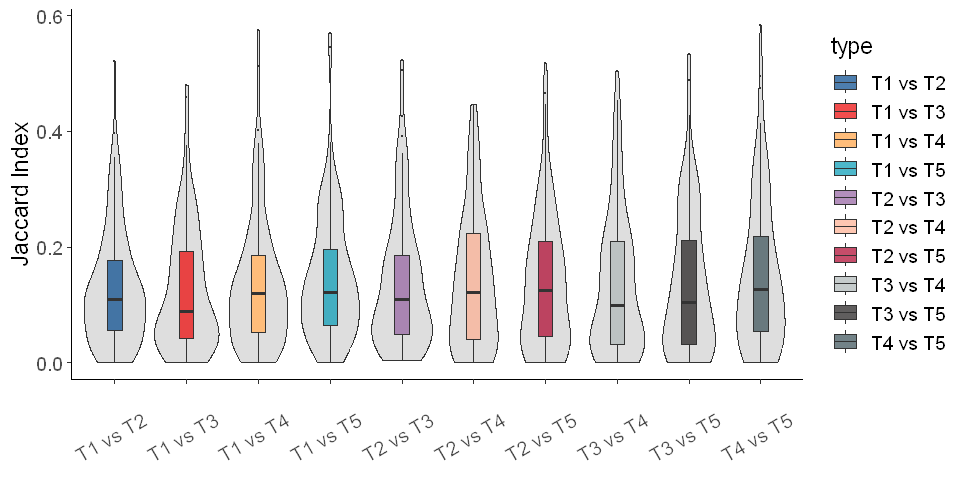

In [8]:
jac_LoT[1:5,]

jac_LoT$type=paste0(jac_LoT$type1," vs ",jac_LoT$type2)

selected_type=c("T1 vs T2","T1 vs T3","T1 vs T4","T1 vs T5",
                "T2 vs T3","T2 vs T4","T2 vs T5",
                "T3 vs T4","T3 vs T5",
                "T4 vs T5")

jac_ToT<-jac_LoT[jac_LoT$type %in% selected_type,]
options(repr.plot.width = 8, repr.plot.height = 4)
g<-ggplot(jac_ToT,aes(x=type,y=jaccard_index,fill=type))+
    geom_violin(aes(x=type,y=jaccard_index),fill="grey",alpha=.5)+
    geom_boxplot(aes(x=type,y=jaccard_index),width=.2,outlier.size = .1)+
#    geom_signif(comparisons = list(c("T4.T5","T1.T3"),c("T1.T2","T1.T4")),
#              map_signif_level=T,
#              textsize=4,test=wilcox.test,step_increase=0.1,vjust=2,tip_length=0.02)+
    theme_classic()+
    theme(text =element_text(size=14),axis.text.x =element_text(size=12,angle=30,vjust=-0.01))+
    xlab("")+ylab("Jaccard Index")+
    scale_fill_manual(values=mypal)

g

In [9]:
jac_LoT[1:5,]
jac_LoT$type1=substr(jac_LoT$sample1,8,9)
jac_LoT$type2=substr(jac_LoT$sample2,8,9)

jac_LoT$distance=ifelse((jac_LoT$type1=="T4" & jac_LoT$type2=="T2")| 
                        (jac_LoT$type1=="T2" & jac_LoT$type2=="T4")|
                        (jac_LoT$type1=="T1" & jac_LoT$type2=="T3")| 
                        (jac_LoT$type1=="T3" & jac_LoT$type2=="T1"),
                        2,
                        ifelse((jac_LoT$type1=="T1" & jac_LoT$type2=="T2")|
                            (jac_LoT$type1=="T2" & jac_LoT$type2=="T1")|
                            (jac_LoT$type1=="T1" & jac_LoT$type2=="T4")|
                            (jac_LoT$type1=="T4" & jac_LoT$type2=="T1")|
                            (jac_LoT$type1=="T3" & jac_LoT$type2=="T2")|
                            (jac_LoT$type1=="T2" & jac_LoT$type2=="T3")|
                            (jac_LoT$type1=="T3" & jac_LoT$type2=="T4")|
                            (jac_LoT$type1=="T4" & jac_LoT$type2=="T3"),1.41,1))

jac_LoT[1:5,]                        

,sample1,sample2,jaccard_index,flag,type1,type2,distance,type
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2045,ESCC081T4,ESCC081T3,0.09668169,self.ToT,T4,T3,Adjacent,T4 vs T3
2367,ESCC081T4,ESCC081T2,0.32505981,self.ToT,T4,T2,Separated,T4 vs T2
2368,ESCC081T4,ESCC081T5,0.26170599,self.ToT,T4,T5,Adjacent,T4 vs T5
2384,ESCC081T4,ESCC081T1,0.32904806,self.ToT,T4,T1,Adjacent,T4 vs T1
2614,ESCC039T1,ESCC039T4,0.18275154,self.ToT,T1,T4,Adjacent,T1 vs T4


,sample1,sample2,jaccard_index,flag,type1,type2,distance,type
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>
2045,ESCC081T4,ESCC081T3,0.09668169,self.ToT,T4,T3,1.41,T4 vs T3
2367,ESCC081T4,ESCC081T2,0.32505981,self.ToT,T4,T2,2.00,T4 vs T2
2368,ESCC081T4,ESCC081T5,0.26170599,self.ToT,T4,T5,1.00,T4 vs T5
2384,ESCC081T4,ESCC081T1,0.32904806,self.ToT,T4,T1,1.41,T4 vs T1
2614,ESCC039T1,ESCC039T4,0.18275154,self.ToT,T1,T4,1.41,T1 vs T4


In [10]:
# 利用k nearest挖掘T1-T5,各自最接近的部位

jac_long<-fread("Fig5G-I.sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_LoT<-jac_long[jac_long$flag=="self.ToT",]

Single_T_jac_level<-tibble()
samples<-unique(jac_LoT$sample1)[order(unique(jac_LoT$sample1),decreasing = FALSE)]
for (s in samples){
    data_s<-jac_LoT[jac_LoT$sample1==s,]
    row_s<-c(s,mean(data_s$jaccard_index),median(data_s$jaccard_index),data_s$sample2[order(data_s$jaccard_index,decreasing = TRUE)[1]])
    Single_T_jac_level<-rbind(Single_T_jac_level,row_s)
}

colnames(Single_T_jac_level)<-c("sample","average_jaccard","median_jaccard","closest_sample")

Single_T_jac_level$closest_pos<-substr(Single_T_jac_level$closest_sample,8,9)
Single_T_jac_level$type<-substr(Single_T_jac_level$sample,8,9)

## Fig5G

,sample,closest_sample,type,closest_pos,sHIG
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,ESCC001T1,ESCC001T5,T1,T5,0.9412713
2,ESCC001T2,ESCC001T3,T2,T3,0.9447720
3,ESCC001T3,ESCC001T5,T3,T5,0.9381510


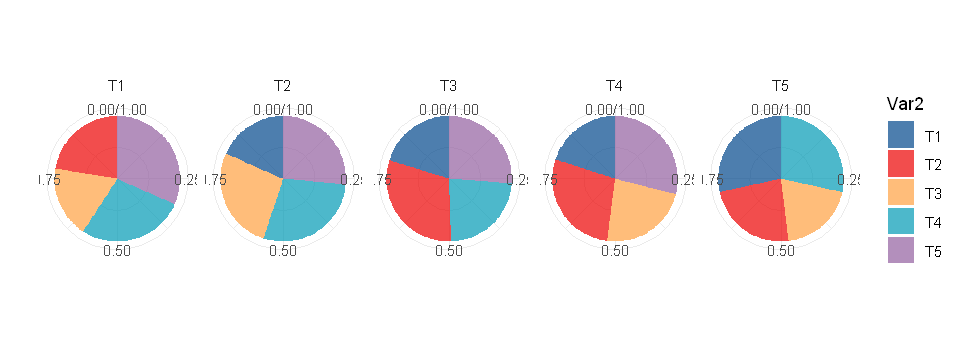

null device 
          1

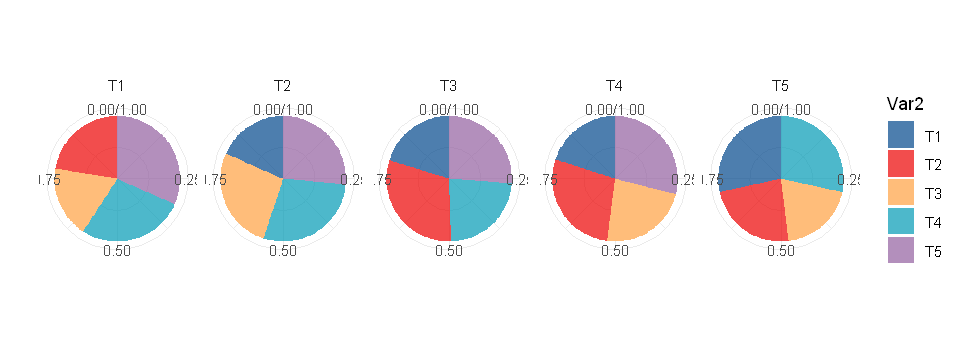

In [11]:
Single_T_jac_level$sHIG=1-as.numeric(Single_T_jac_level$average_jaccard)

sHIG_closest_pos<-Single_T_jac_level[,c(1,4,6,5,7)]
sHIG_closest_pos[1:3,]
colnames(sHIG_closest_pos)=c('sample','sample.nearest','position','position.nearest','sHIG')
#write.csv(sHIG_closest_pos,"Sup.table_sHIG_closest_pos.csv",quote=FALSE,row.names=FALSE)
closest<-table(Single_T_jac_level$type,Single_T_jac_level$closest_pos) %>% as.data.frame()
#data<-rbind(self,closest)
#data<-data[data$Freq!=0,]

options(repr.plot.width = 8, repr.plot.height = 3)
closet_position<-ggplot(data=closest,aes(x="",y=Freq,fill=Var2))+
  geom_bar(width=0.5,stat = "identity", position = "fill")+
  coord_polar("y", start=0)+ facet_wrap(closest$Var1,nrow=1)+
  labs(x="",y="")+scale_fill_manual(values=mypal)+
  theme_minimal()
  #+geom_text(aes(y="fill",label=Freq),size=5)
closet_position
#pdf("Fig3.MR.het.closet_position.pdf",6,3)
#closet_position
dev.off()


In [13]:
write.csv(closest,"Fig5G.csv",quote=FALSE,row.names=FALSE)

## Fig5H


	Wilcoxon rank sum test with continuity correction

data:  x and y
W = 5225.5, p-value = 0.5791
alternative hypothesis: true location shift is not equal to 0


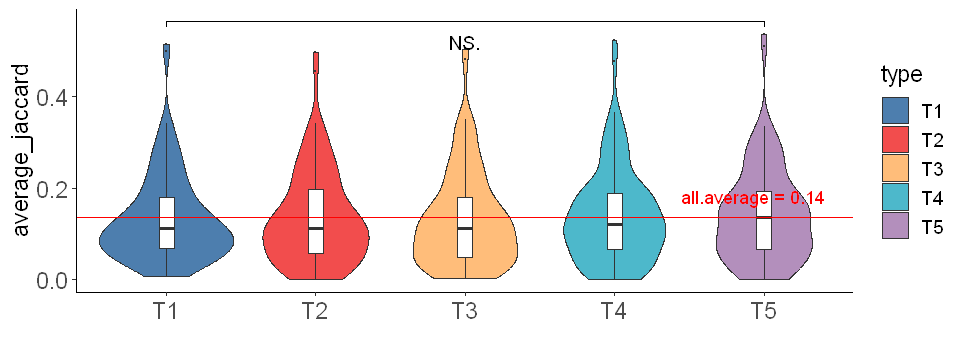

In [14]:
Single_T_jac_level[,2:3]<-apply(Single_T_jac_level[,2:3],2,as.numeric)

Single_T_jac_level$type=substr(Single_T_jac_level$sample,8,9)

x=Single_T_jac_level$average_jaccard[Single_T_jac_level$type=="T5"]
y=Single_T_jac_level$average_jaccard[Single_T_jac_level$type=="T1"]
wilcox.test(x,y)


Jac_T1_T5<-ggplot(Single_T_jac_level,aes(x=type,y=average_jaccard))+
    geom_violin(aes(x=type,y=average_jaccard,fill=type))+
    geom_boxplot(aes(x=type,y=average_jaccard),width=.1,outlier.size = .1)+
   geom_signif(comparisons = list(c("T5","T1")),#,c("T5","T2"),c("T5","T3"),c("T5","T4")),
             map_signif_level=T,
             textsize=4,test=wilcox.test,step_increase=0.1,vjust=2,tip_length=0.02)+
   theme_classic()+geom_hline(yintercept=mean(Single_T_jac_level$average_jaccard),col = "red")+
   annotate("text", x = Inf, y =mean(Single_T_jac_level$average_jaccard), 
           label = paste0("all.average = ",signif(mean(Single_T_jac_level$average_jaccard),digits=2)),
           hjust = 1.2, vjust = -1,col="red")+
    theme(text =element_text(size=14),axis.text =element_text(size=14))+
    xlab("")+ylab("average_jaccard")+
    scale_fill_manual(values=mypal)
Jac_T1_T5

In [15]:
write.csv(Single_T_jac_level,"Fig5H.csv",quote=FALSE,row.names=FALSE)

## Fig5I
计算单个肿瘤样本的突变频率和相对于其他肿瘤的突变频率

In [17]:
db<-fread("all3up_clone-pass_germ-pass_mutation-pass_selected_rows.tsv")%>%as.data.frame()
db$sample=str_split(db$sequence_id,"_",simplify = TRUE)[,1]
db$patient=str_sub(db$sequence_id,1,7)
db$tissue=str_sub(db$sequence_id,8,8)
db$tissue<-factor(db$tissue,levels=c("T","N","L"),ordered = TRUE)
#db$c_call<-factor(db$c_call,levels=c("IGHD","IGHM","IGHA1","IGHA2","IGHG1","IGHG2","IGHG3","IGHG4","IGHE"),ordered = TRUE)
db$with_l<-""
patients_with_L<-db$patient[db$tissue=="L"] %>% unique()
patients_with_L %>%length()

db$with_l[db$patient %in% patients_with_L]<-"with_L"
db$with_l[!db$patient %in% patients_with_L]<-"without_L"
db_with_L<-db[db$with_l=="with_L",]

### step1 计算所有T样本的平均和中位数突变频率
T_data<-db[db$tissue=="T",]

T_sample_mutation_level<-tibble()
samples<-unique(T_data$sample)[order(unique(T_data$sample),decreasing = FALSE)]
for (s in samples){
    data_s<-T_data[T_data$sample==s,]
    
    p=substr(s,1,7)
    data_T_other<-T_data[T_data$patient==p & T_data$sample!=s,]
    meanT=mean(data_T_other$mu_freq)
    medianT=median(data_T_other$mu_freq)

    row_s<-c(s,mean(data_s$mu_freq),median(data_s$mu_freq),mean(data_s$mu_freq)-meanT,median(data_s$mu_freq)-medianT)
    T_sample_mutation_level<-rbind(T_sample_mutation_level,row_s)
}

colnames(T_sample_mutation_level)<-c("sample","average_mutation","median_mutation","delta_average_mutation","delta_median_mutation")
T_sample_mutation_level[1:3,]

#比较T1-T5各部位与其他部位突变频率的差值
T_sample_mutation_level[,2:5]<-apply(T_sample_mutation_level[,2:5],2,as.numeric)

T_sample_mutation_level$patient<-substr(T_sample_mutation_level$sample,1,7)
T_sample_mutation_level$type<-substr(T_sample_mutation_level$sample,8,9)

[1] 27

,sample,average_mutation,median_mutation,delta_average_mutation,delta_median_mutation
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ESCC001T1,0.063905644572329,0.0607142857142857,-0.00864156528314781,-0.0113860277653381
2,ESCC001T2,0.0705095813460799,0.0708705357142857,-0.000896629822227421,6.15407532689044e-05
3,ESCC001T3,0.0704791649909046,0.0701486949080017,-0.00135321972138021,-0.00163582422483695


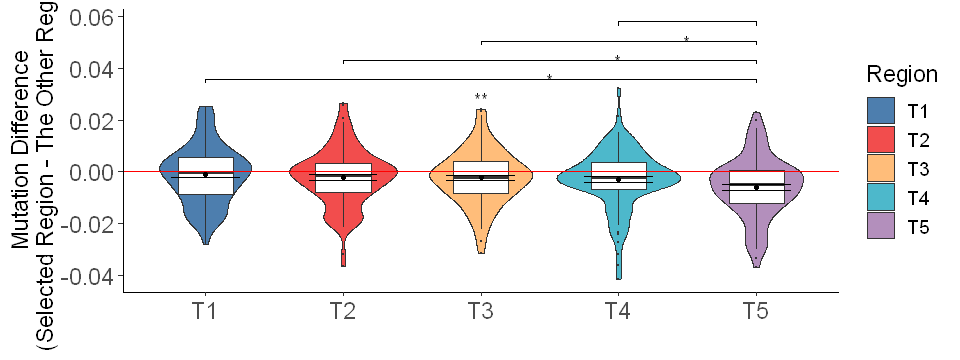

In [18]:
#ggplot(T_sample_mutation_level,aes(x=type,y=delta_average_mutation))+geom_violin()+geom_boxplot()
data<-T_sample_mutation_level

colnames(data)[grep("type",colnames(data))]="Region"
data_summary <- data %>% group_by(Region) %>% summarise(mean_delta=mean(delta_average_mutation),
                                        se_delta = sd(delta_average_mutation)/sqrt(n()),
                                        )



T1_T5_delta_mut<-ggplot(data,aes(x=Region,y=delta_average_mutation))+
    geom_violin(aes(x=Region,y=delta_average_mutation,fill=Region))+
    geom_boxplot(aes(x=Region,y=delta_average_mutation),width=.4,outlier.size = .1)+
    geom_point(data = data_summary, aes(x = Region, y = mean_delta, group = Region),fill = "black", size = 1) +
  geom_errorbar(data = data_summary, aes(x = Region, y = mean_delta, ymin = mean_delta - se_delta, ymax = mean_delta + se_delta), width = .5) +
    geom_signif(comparisons = list(c("T5","T1"),c("T5","T2"),c("T5","T3"),c("T5","T4")),
              map_signif_level=T,
              textsize=4,test=wilcox.test,step_increase=0.1,vjust=2,tip_length=0.02)+
    theme_classic()+geom_hline(yintercept=0,col = "red")+
    theme(text =element_text(size=14),axis.text =element_text(size=14))+
    xlab("")+ylab("Mutation Difference\n(Selected Region - The Other Regions)")+
    scale_fill_manual(values=mypal)

    T1_T5_delta_mut

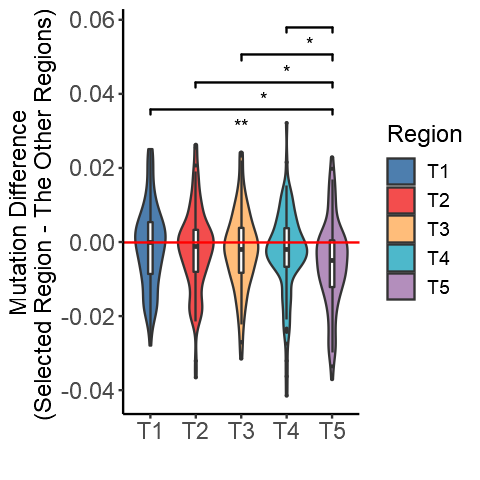

null device 
          1

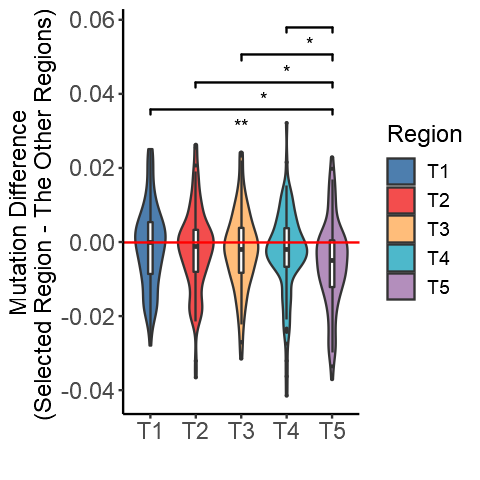

In [36]:
pdf("Fig5I.MR_het.delta_mutation.pdf",5,3)
T1_T5_delta_mut
dev.off()

In [20]:
write.csv(data,"Fig5I.csv",quote=FALSE,row.names=FALSE)